# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 

Imports 

In [165]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from tqdm.auto import tqdm

In [2]:
!nvidia-smi

Sat Apr  8 20:27:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:17:00.0 Off |                    0 |
|  0%   59C    P0   133W / 300W |      0MiB /  5067MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [232]:
# Transformations type : https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_train_1 = transforms.Compose([
    transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
    transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
    transforms.RandomRotation(10),     #Rotates the image to a specified angel
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
    transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
])
 
transform_train_2 = transforms.Compose([
    #transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=[32,32], padding=4),
    transforms.RandomRotation(degrees=(-30, 30)),
    #transforms.RandomAdjustSharpness(sharpness_factor=2),
    #transforms.RandomResizedCrop(size=(32, 32)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
])

In [233]:
transform_train = transform_train_2

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [234]:
# transform = transforms.Compose([transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [235]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [236]:
testset, trainset

(Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomCrop(size=(32, 32), padding=4)
                RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

## Data Preprocessing

In [284]:
BATCH_SIZE = 4
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

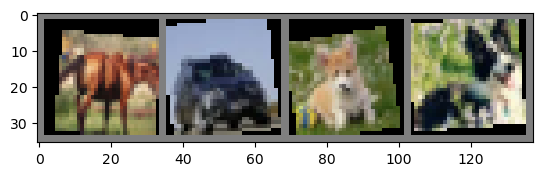

horse car   dog   dog  


In [286]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


In [211]:
# print size of data in batch

for d in trainloader:
    print(d[0].shape)
    break

torch.Size([8, 3, 32, 32])


## Model

In [212]:
# Parameters 


N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

In [213]:
class ConvBlock(nn.Sequential):

    def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL):
        
        super(ConvBlock, self).__init__(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            #nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            #nn.Dropout2d(p=0.5),
        )

In [214]:
class Backbone(nn.Module):

    def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=False):
        super(Backbone, self).__init__()

        # Boolean to print debug logs.
        self.debug = debug

        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.linear = nn.Sequential(
            nn.Linear(in_features=in_channels, out_features=k, bias=False),   # Question, can this be MLP?
            #nn.Tanh(),
            # nn.LeakyReLU(),
            # nn.Linear(in_features=k, out_features=k, bias=True),  
            #nn.ReLU(),
            nn.Sigmoid(),      # Non Linear Activation
        )

        self.conv_blocks = nn.ModuleList([
            ConvBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
            for _ in range(k)
        ])

        self.batch_norm = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
        sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"{sap_out.shape=}")

        g_out = self.linear(sap_out)
        if self.debug: print(f"{g_out.shape=}")
        if self.debug: print(f"{g_out=}")

        outs = list()
        for a, conv_block in zip(g_out.transpose(0, 1), self.conv_blocks):
        #for conv2d in self.conv2ds:
            c_out = conv_block(x)
            if self.debug: print(f"{c_out.shape=}")
            if self.debug: print(f"{a.shape=}, \n{a=}")

            out = a.reshape(x.shape[0], 1, 1, 1)*c_out
            if self.debug: print(f"{out.shape=}")
            outs.append(out)
            #outs.append(c_out)

        out = sum(outs)
        if self.debug: print(f"{out.shape=}")

        #out = self.batch_norm(out)
        #if self.debug: print(f"batch_{out.shape=}")

        return out

In [215]:
class Classifier(nn.Module):
    
    def __init__(self, in_features, out_features, debug=True):
        
        super(Classifier, self).__init__()
        self.debug = debug
        
        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.mlp = nn.Sequential(
            #nn.Linear(in_features=in_features, out_features=in_features * 2 // 3, bias=False),
            #nn.Dropout(p=0.2),
            #nn.ReLU(),
            #nn.Linear(in_features=in_features * 2 // 3, out_features=in_features // 3, bias=False),
            #nn.Dropout(p=0.2),
            #nn.ReLU(),
            #nn.Linear(in_features=in_features // 3, out_features=len(CLASSES), bias=False),
            nn.Linear(in_features=in_features, out_features=out_features, bias=True),
        )
        
    def forward(self, x):
        
        f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"Classifier: {f.shape=}")

        out = self.mlp(f)
        if self.debug: print(f"Classifier: {out.shape=}")

        return out

In [298]:
class Model(nn.Module):
    
    def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
        
        super(Model, self).__init__()
        
        self.debug = debug   # Boolean to print debug logs.
        self.Ks = Ks
        self.channels = channels
        self.n = n

        self.backbones = nn.Sequential(*[
            Backbone(
                in_channels=self.channels[i], 
                out_channels=self.channels[i+1], 
                kernel_size=kernel_size, 
                k=self.Ks[i], 
                debug=debug
            ) 
            for i in range(self.n)
        ])
        
        self.classifier = Classifier(in_features=self.channels[-1], out_features=len(CLASSES), debug=debug)

    def set_debug(self, debug=True):
        
        self.debug = debug
        for backbone in self.backbones:
            backbone.debug = debug
        self.classifier.debug = debug

    def forward(self, x):
        x = self.backbones(x)
        #for backbone in self.backbones:
        #    x = backbone(x)
    
        out = self.classifier(x)

        return out

In [488]:
class Trainer:
    
    def __init__(self, model, criterion, optimizer, scheduler, trainloader, testloader, logs_per_epoch=4) -> None:
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        self.epochs = 0
        self.log_step = len(trainloader) // logs_per_epoch

        self.trainloader = trainloader
        self.testloader = testloader
        
        self.lrs = list()
        self.losses = list()
        self.val_losses = list()
        self.batch_losses = list()

        self.train_accuracy = list()
        self.val_accuracy = list()
        
    
    def train(self, epochs=3, use_gpu=False):
        
        for epoch in range(self.epochs, self.epochs + epochs):  # loop over the dataset multiple times

            batch_losses = list()
            running_loss = 0.0
            correct = 0
            total = 0
        
            self.model.train()
            
            for i, data in tqdm(enumerate(self.trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch + 1} "):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.to('cuda')
                    labels = labels.to('cuda')

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                # Accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Print statistics
                batch_losses.append(loss.item())
                running_loss += loss.item()
                if i % self.log_step == self.log_step-1:    # print every 2000 mini-batches
                    avg_loss = running_loss / self.log_step
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                    running_loss = 0.0
                    self.batch_losses.append(avg_loss)

            self.losses.append(sum(batch_losses) / len(batch_losses))
            print(f"Train Loss : {self.losses[-1]}")
            
            # Calculate accuracy
            accuracy = correct / total
            self.train_accuracy.append(accuracy)
            print(f'Train Accuracy : {100 * accuracy:.2f} %')
            
            # Save Learning rate.
            #print(f"{self.scheduler.get_last_lr()=}")
            #print(f"{self.optimizer.param_groups[0]['lr']=}")
            self.lrs.append(self.optimizer.param_groups[0]['lr'])
            
            val_loss = self.eval()
            self.scheduler.step()

        self.epochs += epochs
        print('Finished Training')
    
    
    def eval(self):
        correct = 0
        total = 0
        losses = list()
        
        self.model.eval()
        
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                if USE_GPU:
                    images = images.to('cuda')
                    labels = labels.to('cuda')

                # calculate outputs by running images through the network
                outputs = self.model(images)

                loss = self.criterion(outputs, labels)
                losses.append(loss.item())

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()


        val_loss = sum(losses) / len(losses)
        self.val_losses.append(val_loss)

        print(f"Val Loss : {val_loss}")

        accuracy = correct / total
        self.val_accuracy.append(accuracy)
        print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
        
        return val_loss
    
    def plot(self):
        fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
        fig.set_size_inches(15, 3)
        
        epochs_x = range(1, self.epochs+1)
        
        ax0.plot(epochs_x, self.lrs, label="LR", color='C3', lw=3, alpha=1)
        ax0.legend()
        ax0.set_yscale('log')
        ax0.set(title=f'Learning Rates', xlabel='Epoch', ylabel='Learning rate')

        X = np.linspace(1, len(self.losses), len(self.batch_losses))
        ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', linestyle='dashed', lw=1, alpha=0.7)
        ax1.plot(epochs_x, self.losses, label='Train', color='C0', lw=3, alpha=1)
        ax1.plot(epochs_x, self.val_losses, label='Test', color='C1', lw=3, alpha=1)
        ax1.legend()
        ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')
        
        ax2.plot(epochs_x, self.train_accuracy, label="Train", color='C0', lw=3, alpha=1)
        ax2.plot(epochs_x, self.val_accuracy, label="Test", color='C1', lw=3, alpha=1)
        ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
        ax2.legend()
        
        plt.tight_layout()
        fig.show()
    

In [489]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

In [490]:
def model_summary(model, trainloader):

    img_sizes = list()
    
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            if USE_GPU:
                images = images.to('cuda')
                labels = labels.to('cuda')
            
            x = images
            
            img_sizes.append(x.shape[-1])
            for backbone in model.backbones:
                x = backbone(x)
                img_sizes.append(x.shape[-1])
            break
                
    print(f"{model.channels=}")
    print(f"{model.Ks=}")
    print(f"{model.n=}")
    print(f"{img_sizes=}")

## Experiment

In [494]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 3
STRIDE = 1

# channels = [IMG_CHANNELS, 16, 32, 64, 64] #20, 25, 30]
# channels = [IMG_CHANNELS, 4, 8, 16, ]
# channels = [IMG_CHANNELS, 5, 7, 9, 11, 13]
channels = [IMG_CHANNELS, 64, 128, 256, 512, 1028] 
# Ks = channels[1:]
Ks = [3] * (len(channels) - 1)
N = len(channels) - 1

model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)

if USE_GPU: model.to('cuda')
model.set_debug(False)
model_summary(model=model, trainloader=trainloader)
model

model.channels=[3, 64, 128, 256, 512, 1028]
model.Ks=[3, 3, 3, 3, 3]
model.n=5
img_sizes=[32, 16, 8, 4, 2, 1]


Model(
  (backbones): Sequential(
    (0): Backbone(
      (spaitial_average_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (linear): Sequential(
        (0): Linear(in_features=3, out_features=3, bias=False)
        (1): Sigmoid()
      )
      (conv_blocks): ModuleList(
        (0): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (1): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (2): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(

In [495]:
# Init optimizer 

LR = 1e-3 #1e-3, 1e-4
LR_STEP_SIZE = 10
WEIGHT_DECAY = 0.05 # 0.15


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

constant_scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=20)
linear_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.3333333333333333, end_factor=1.0, total_iters=20, last_epoch=- 1, verbose=False)
polynomial_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=20, power=1.0, last_epoch=- 1, verbose=False)
exponential_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
cyclic_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=3e-4, step_size_up=5, step_size_down=None, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=False, base_momentum=0.8, max_momentum=0.9, last_epoch=- 1, verbose=False)
one_cycle_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-5, total_steps=30, epochs=None, steps_per_epoch=None, pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, three_phase=False, last_epoch=-1, verbose=False)
reduce_on_plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

sequential_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[polynomial_scheduler, cyclic_scheduler], milestones=[20])#, last_epoch=60)

scheduler = sequential_scheduler

optimizer.param_groups[0]['lr'] = LR

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 10, 10, 10, 10, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


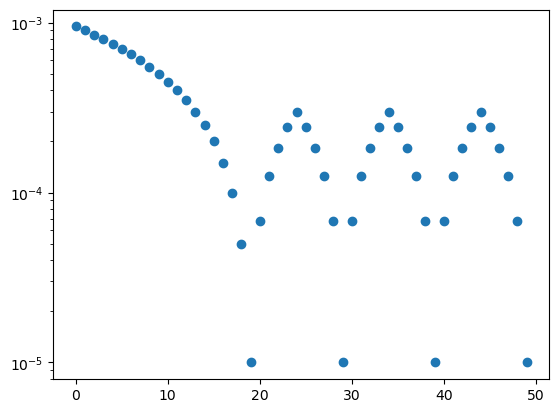

In [493]:
lrs_ = list()
values = list(range(10, 0, -1)) + list(range(0, 20)) + [10]*5 + list(range(10, 0, -1)) + list(range(0, 10)) + list(range(10, 0, -1)) + list(range(0, 10)) + list(range(10, 0, -1))
print(values)
for i in range(50):
    optimizer.step()
    #scheduler.step(values[i])
    scheduler.step()
    #lrs_.append(scheduler.get_last_lr())
    lrs_.append(optimizer.param_groups[0]['lr'])
    
fig, ax = plt.subplots(1)
ax.scatter(range(len(lrs_)), lrs_)
ax.set_yscale('log')

In [496]:
# Init Trainer

BATCH_SIZE = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    logs_per_epoch=4,
    trainloader=trainloader,
    testloader=testloader,
)

Epoch 1 :   0%|          | 0/196 [00:00<?, ?it/s]

[1,    49] loss: 2.341
[1,    98] loss: 2.151
[1,   147] loss: 2.053
[1,   196] loss: 1.968
Train Loss : 2.1281732296457094
Train Accuracy : 20.88 %
Val Loss : 1.9654144555330277
Accuracy of the network on the 10000 test images: 26.43 %


Epoch 2 :   0%|          | 0/196 [00:00<?, ?it/s]

[2,    49] loss: 1.890
[2,    98] loss: 1.816
[2,   147] loss: 1.707
[2,   196] loss: 1.581
Train Loss : 1.7485056337045164
Train Accuracy : 35.99 %
Val Loss : 1.5489171147346497
Accuracy of the network on the 10000 test images: 43.98 %


Epoch 3 :   0%|          | 0/196 [00:00<?, ?it/s]

[3,    49] loss: 1.518
[3,    98] loss: 1.458
[3,   147] loss: 1.382
[3,   196] loss: 1.352
Train Loss : 1.4276343663128055
Train Accuracy : 48.63 %
Val Loss : 1.393373829126358
Accuracy of the network on the 10000 test images: 52.80 %


Epoch 4 :   0%|          | 0/196 [00:00<?, ?it/s]

[4,    49] loss: 1.315
[4,    98] loss: 1.276
[4,   147] loss: 1.232
[4,   196] loss: 1.198
Train Loss : 1.2553216060813592
Train Accuracy : 55.06 %
Val Loss : 1.1992054104804992
Accuracy of the network on the 10000 test images: 56.26 %


Epoch 5 :   0%|          | 0/196 [00:00<?, ?it/s]

[5,    49] loss: 1.183
[5,    98] loss: 1.159
[5,   147] loss: 1.100
[5,   196] loss: 1.107
Train Loss : 1.1374248174988493
Train Accuracy : 59.35 %
Val Loss : 1.0294446304440499
Accuracy of the network on the 10000 test images: 64.09 %


Epoch 6 :   0%|          | 0/196 [00:00<?, ?it/s]

[6,    49] loss: 1.069
[6,    98] loss: 1.053
[6,   147] loss: 1.031
[6,   196] loss: 1.022
Train Loss : 1.0435241591565463
Train Accuracy : 63.07 %
Val Loss : 0.9537718310952187
Accuracy of the network on the 10000 test images: 66.58 %


Epoch 7 :   0%|          | 0/196 [00:00<?, ?it/s]

[7,    49] loss: 0.989
[7,    98] loss: 0.973
[7,   147] loss: 0.961
[7,   196] loss: 0.952
Train Loss : 0.968679668343797
Train Accuracy : 65.67 %
Val Loss : 1.0240957200527192
Accuracy of the network on the 10000 test images: 64.19 %


Epoch 8 :   0%|          | 0/196 [00:00<?, ?it/s]

[8,    49] loss: 0.930
[8,    98] loss: 0.920
[8,   147] loss: 0.915
[8,   196] loss: 0.900
Train Loss : 0.916313208487569
Train Accuracy : 67.92 %
Val Loss : 0.8985486149787902
Accuracy of the network on the 10000 test images: 69.97 %


Epoch 9 :   0%|          | 0/196 [00:00<?, ?it/s]

[9,    49] loss: 0.876
[9,    98] loss: 0.870
[9,   147] loss: 0.843
[9,   196] loss: 0.835
Train Loss : 0.8561786504424348
Train Accuracy : 69.84 %
Val Loss : 0.8223392948508262
Accuracy of the network on the 10000 test images: 71.15 %


Epoch 10 :   0%|          | 0/196 [00:00<?, ?it/s]

[10,    49] loss: 0.822
[10,    98] loss: 0.811
[10,   147] loss: 0.810
[10,   196] loss: 0.817
Train Loss : 0.8149960034964036
Train Accuracy : 71.17 %
Val Loss : 0.7860319688916206
Accuracy of the network on the 10000 test images: 72.91 %
Finished Training


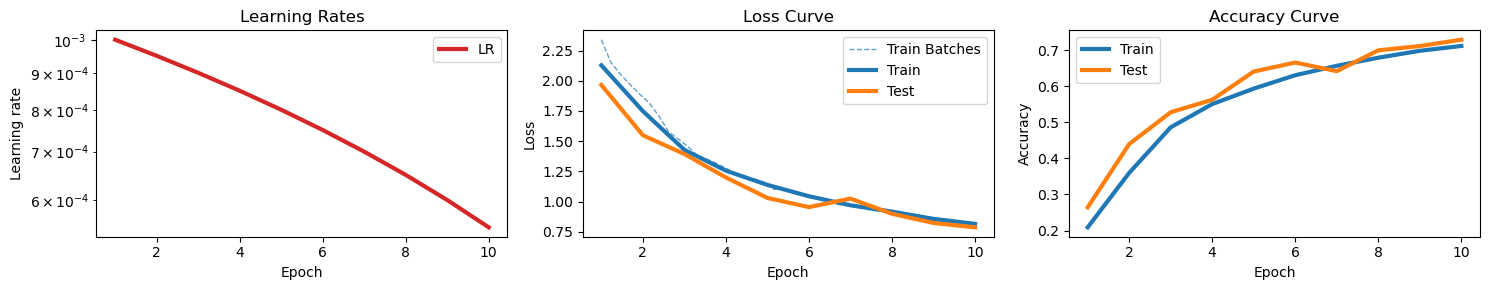

In [497]:
trainer.train(epochs=10, use_gpu=USE_GPU)
trainer.plot()

Epoch 11 :   0%|          | 0/196 [00:00<?, ?it/s]

[11,    49] loss: 0.792
[11,    98] loss: 0.757
[11,   147] loss: 0.768
[11,   196] loss: 0.771
Train Loss : 0.7719999013506637
Train Accuracy : 72.92 %
Val Loss : 0.7207096233963967
Accuracy of the network on the 10000 test images: 75.16 %


Epoch 12 :   0%|          | 0/196 [00:00<?, ?it/s]

[12,    49] loss: 0.740
[12,    98] loss: 0.745
[12,   147] loss: 0.723
[12,   196] loss: 0.737
Train Loss : 0.7360849550792149
Train Accuracy : 74.16 %
Val Loss : 0.8286538451910019
Accuracy of the network on the 10000 test images: 71.87 %


Epoch 13 :   0%|          | 0/196 [00:00<?, ?it/s]

[13,    49] loss: 0.697
[13,    98] loss: 0.711
[13,   147] loss: 0.693
[13,   196] loss: 0.703
Train Loss : 0.7007838721786227
Train Accuracy : 75.36 %
Val Loss : 0.7386316582560539
Accuracy of the network on the 10000 test images: 75.36 %


Epoch 14 :   0%|          | 0/196 [00:00<?, ?it/s]

[14,    49] loss: 0.665
[14,    98] loss: 0.666
[14,   147] loss: 0.663
[14,   196] loss: 0.670
Train Loss : 0.665886864066124
Train Accuracy : 76.61 %
Val Loss : 0.6783230893313885
Accuracy of the network on the 10000 test images: 77.65 %


Epoch 15 :   0%|          | 0/196 [00:00<?, ?it/s]

[15,    49] loss: 0.624
[15,    98] loss: 0.636
[15,   147] loss: 0.642
[15,   196] loss: 0.628
Train Loss : 0.6327775820177428
Train Accuracy : 77.80 %
Val Loss : 0.6520634606480599
Accuracy of the network on the 10000 test images: 78.05 %


Epoch 16 :   0%|          | 0/196 [00:00<?, ?it/s]

[16,    49] loss: 0.602
[16,    98] loss: 0.606
[16,   147] loss: 0.598
[16,   196] loss: 0.603
Train Loss : 0.6023629304705834
Train Accuracy : 78.68 %
Val Loss : 0.6362378217279911
Accuracy of the network on the 10000 test images: 78.98 %


Epoch 17 :   0%|          | 0/196 [00:00<?, ?it/s]

[17,    49] loss: 0.584
[17,    98] loss: 0.584
[17,   147] loss: 0.571
[17,   196] loss: 0.568
Train Loss : 0.5765966532789931
Train Accuracy : 79.45 %
Val Loss : 0.6066966511309146
Accuracy of the network on the 10000 test images: 79.42 %


Epoch 18 :   0%|          | 0/196 [00:00<?, ?it/s]

[18,    49] loss: 0.561
[18,    98] loss: 0.547
[18,   147] loss: 0.547
[18,   196] loss: 0.546
Train Loss : 0.5503486768931759
Train Accuracy : 80.66 %
Val Loss : 0.5655384913086892
Accuracy of the network on the 10000 test images: 80.67 %


Epoch 19 :   0%|          | 0/196 [00:00<?, ?it/s]

[19,    49] loss: 0.522
[19,    98] loss: 0.536
[19,   147] loss: 0.526
[19,   196] loss: 0.532
Train Loss : 0.529093784793299
Train Accuracy : 81.31 %
Val Loss : 0.5426071308553219
Accuracy of the network on the 10000 test images: 81.29 %


Epoch 20 :   0%|          | 0/196 [00:00<?, ?it/s]

[20,    49] loss: 0.502
[20,    98] loss: 0.514
[20,   147] loss: 0.511
[20,   196] loss: 0.510
Train Loss : 0.5092786147582288
Train Accuracy : 81.89 %
Val Loss : 0.5403776958584785
Accuracy of the network on the 10000 test images: 82.18 %


Epoch 21 :   0%|          | 0/196 [00:00<?, ?it/s]

[21,    49] loss: 0.495
[21,    98] loss: 0.499
[21,   147] loss: 0.486
[21,   196] loss: 0.490
Train Loss : 0.49246179662188705
Train Accuracy : 82.65 %
Val Loss : 0.5289550639688969
Accuracy of the network on the 10000 test images: 82.31 %


Epoch 22 :   0%|          | 0/196 [00:00<?, ?it/s]

[22,    49] loss: 0.495
[22,    98] loss: 0.509
[22,   147] loss: 0.500
[22,   196] loss: 0.505
Train Loss : 0.5022281864467932
Train Accuracy : 82.31 %
Val Loss : 0.5410640954971313
Accuracy of the network on the 10000 test images: 82.03 %


Epoch 23 :   0%|          | 0/196 [00:00<?, ?it/s]

[23,    49] loss: 0.499
[23,    98] loss: 0.505
[23,   147] loss: 0.512
[23,   196] loss: 0.539
Train Loss : 0.5136040030997626
Train Accuracy : 81.86 %
Val Loss : 0.5318179860711097
Accuracy of the network on the 10000 test images: 81.61 %


Epoch 24 :   0%|          | 0/196 [00:00<?, ?it/s]

[24,    49] loss: 0.517
[24,    98] loss: 0.528
[24,   147] loss: 0.520
[24,   196] loss: 0.532
Train Loss : 0.524334612397515
Train Accuracy : 81.45 %
Val Loss : 0.5907566733658314
Accuracy of the network on the 10000 test images: 80.73 %


Epoch 25 :   0%|          | 0/196 [00:00<?, ?it/s]

[25,    49] loss: 0.520
[25,    98] loss: 0.526
[25,   147] loss: 0.535
[25,   196] loss: 0.544
Train Loss : 0.5313356223763251
Train Accuracy : 81.43 %
Val Loss : 0.5587428338825703
Accuracy of the network on the 10000 test images: 81.21 %


Epoch 26 :   0%|          | 0/196 [00:00<?, ?it/s]

[26,    49] loss: 0.527
[26,    98] loss: 0.545
[26,   147] loss: 0.547
[26,   196] loss: 0.537
Train Loss : 0.5389931807104422
Train Accuracy : 80.96 %
Val Loss : 0.5942449353635311
Accuracy of the network on the 10000 test images: 80.10 %


Epoch 27 :   0%|          | 0/196 [00:00<?, ?it/s]

[27,    49] loss: 0.509
[27,    98] loss: 0.513
[27,   147] loss: 0.520
[27,   196] loss: 0.522
Train Loss : 0.5163219847849437
Train Accuracy : 81.84 %
Val Loss : 0.5524869009852409
Accuracy of the network on the 10000 test images: 81.51 %


Epoch 28 :   0%|          | 0/196 [00:00<?, ?it/s]

[28,    49] loss: 0.502
[28,    98] loss: 0.492
[28,   147] loss: 0.485
[28,   196] loss: 0.493
Train Loss : 0.4928976415979619
Train Accuracy : 82.60 %
Val Loss : 0.5207342840731144
Accuracy of the network on the 10000 test images: 82.15 %


Epoch 29 :   0%|          | 0/196 [00:00<?, ?it/s]

[29,    49] loss: 0.477
[29,    98] loss: 0.470
[29,   147] loss: 0.455
[29,   196] loss: 0.457
Train Loss : 0.46488665941418433
Train Accuracy : 83.42 %
Val Loss : 0.5214242748916149
Accuracy of the network on the 10000 test images: 82.41 %


Epoch 30 :   0%|          | 0/196 [00:00<?, ?it/s]

[30,    49] loss: 0.434
[30,    98] loss: 0.429
[30,   147] loss: 0.440
[30,   196] loss: 0.450
Train Loss : 0.43828446053120557
Train Accuracy : 84.58 %
Val Loss : 0.509759297221899
Accuracy of the network on the 10000 test images: 82.89 %


Epoch 31 :   0%|          | 0/196 [00:00<?, ?it/s]

[31,    49] loss: 0.413
[31,    98] loss: 0.426
[31,   147] loss: 0.419
[31,   196] loss: 0.412
Train Loss : 0.41749267629822906
Train Accuracy : 85.24 %
Val Loss : 0.4956508204340935
Accuracy of the network on the 10000 test images: 83.42 %


Epoch 32 :   0%|          | 0/196 [00:00<?, ?it/s]

[32,    49] loss: 0.417
[32,    98] loss: 0.432
[32,   147] loss: 0.437
[32,   196] loss: 0.442
Train Loss : 0.43183050897656655
Train Accuracy : 84.81 %
Val Loss : 0.5035157077014446
Accuracy of the network on the 10000 test images: 83.03 %


Epoch 33 :   0%|          | 0/196 [00:00<?, ?it/s]

[33,    49] loss: 0.443
[33,    98] loss: 0.446
[33,   147] loss: 0.454
[33,   196] loss: 0.433
Train Loss : 0.4439572567234234
Train Accuracy : 84.23 %
Val Loss : 0.5191387422382832
Accuracy of the network on the 10000 test images: 82.91 %


Epoch 34 :   0%|          | 0/196 [00:00<?, ?it/s]

[34,    49] loss: 0.457
[34,    98] loss: 0.455
[34,   147] loss: 0.453
[34,   196] loss: 0.457
Train Loss : 0.45552248158016984
Train Accuracy : 83.67 %
Val Loss : 0.543403185904026
Accuracy of the network on the 10000 test images: 81.71 %


Epoch 35 :   0%|          | 0/196 [00:00<?, ?it/s]

[35,    49] loss: 0.438
[35,    98] loss: 0.468
[35,   147] loss: 0.466
[35,   196] loss: 0.481
Train Loss : 0.46356963974480725
Train Accuracy : 83.61 %
Val Loss : 0.5354709215462208
Accuracy of the network on the 10000 test images: 81.98 %


Epoch 36 :   0%|          | 0/196 [00:00<?, ?it/s]

[36,    49] loss: 0.485
[36,    98] loss: 0.482
[36,   147] loss: 0.471
[36,   196] loss: 0.495
Train Loss : 0.4833748190074551
Train Accuracy : 82.86 %
Val Loss : 0.5452954426407814
Accuracy of the network on the 10000 test images: 81.34 %


Epoch 37 :   0%|          | 0/196 [00:00<?, ?it/s]

[37,    49] loss: 0.467
[37,    98] loss: 0.448
[37,   147] loss: 0.453
[37,   196] loss: 0.458
Train Loss : 0.45649939760261654
Train Accuracy : 83.73 %
Val Loss : 0.540121427923441
Accuracy of the network on the 10000 test images: 81.90 %


Epoch 38 :   0%|          | 0/196 [00:00<?, ?it/s]

[38,    49] loss: 0.430
[38,    98] loss: 0.420
[38,   147] loss: 0.443
[38,   196] loss: 0.440
Train Loss : 0.43308103677569604
Train Accuracy : 84.68 %
Val Loss : 0.502754519879818
Accuracy of the network on the 10000 test images: 83.57 %


Epoch 39 :   0%|          | 0/196 [00:00<?, ?it/s]

[39,    49] loss: 0.414
[39,    98] loss: 0.406
[39,   147] loss: 0.403
[39,   196] loss: 0.391
Train Loss : 0.403410228235381
Train Accuracy : 85.64 %
Val Loss : 0.5443263538181782
Accuracy of the network on the 10000 test images: 82.24 %


Epoch 40 :   0%|          | 0/196 [00:00<?, ?it/s]

[40,    49] loss: 0.394
[40,    98] loss: 0.380
[40,   147] loss: 0.370
[40,   196] loss: 0.380
Train Loss : 0.38119895649807795
Train Accuracy : 86.45 %
Val Loss : 0.48207503855228423
Accuracy of the network on the 10000 test images: 84.03 %
Finished Training


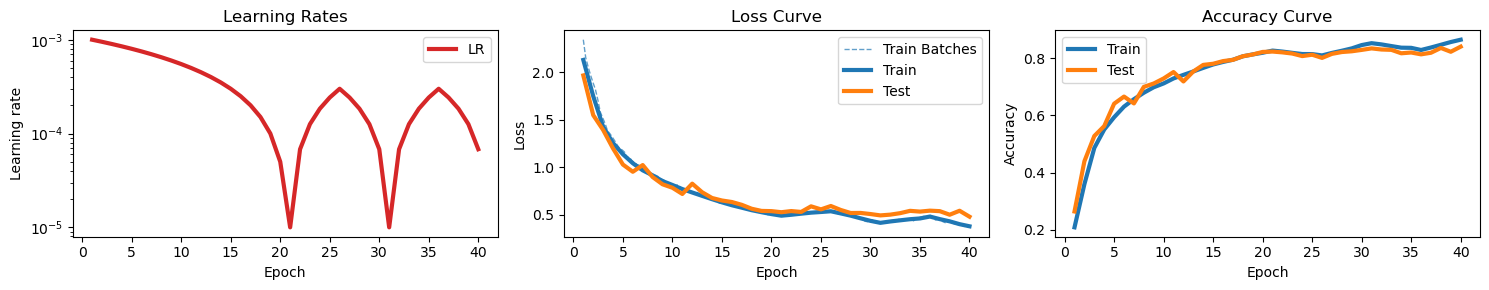

In [498]:
trainer.train(epochs=30, use_gpu=USE_GPU)
trainer.plot()

Epoch 41 :   0%|          | 0/196 [00:00<?, ?it/s]

[41,    49] loss: 0.364
[41,    98] loss: 0.361
[41,   147] loss: 0.375
[41,   196] loss: 0.361
Train Loss : 0.36520317698619803
Train Accuracy : 87.17 %
Val Loss : 0.47478785142302515
Accuracy of the network on the 10000 test images: 84.31 %


Epoch 42 :   0%|          | 0/196 [00:00<?, ?it/s]

[42,    49] loss: 0.363
[42,    98] loss: 0.360
[42,   147] loss: 0.377
[42,   196] loss: 0.373
Train Loss : 0.3681634088255921
Train Accuracy : 87.03 %
Val Loss : 0.48468578010797503
Accuracy of the network on the 10000 test images: 84.22 %


Epoch 43 :   0%|          | 0/196 [00:00<?, ?it/s]

[43,    49] loss: 0.384
[43,    98] loss: 0.384
[43,   147] loss: 0.392
[43,   196] loss: 0.383
Train Loss : 0.38577012717723846
Train Accuracy : 86.46 %
Val Loss : 0.4954207919538021
Accuracy of the network on the 10000 test images: 83.55 %


Epoch 44 :   0%|          | 0/196 [00:00<?, ?it/s]

[44,    49] loss: 0.396
[44,    98] loss: 0.399
[44,   147] loss: 0.395
[44,   196] loss: 0.406
Train Loss : 0.3990608760896994
Train Accuracy : 85.91 %
Val Loss : 0.5122558169066906
Accuracy of the network on the 10000 test images: 83.37 %


Epoch 45 :   0%|          | 0/196 [00:00<?, ?it/s]

[45,    49] loss: 0.411
[45,    98] loss: 0.411
[45,   147] loss: 0.416
[45,   196] loss: 0.427
Train Loss : 0.4163463766477546
Train Accuracy : 85.23 %
Val Loss : 0.5007705360651016
Accuracy of the network on the 10000 test images: 83.16 %


Epoch 46 :   0%|          | 0/196 [00:00<?, ?it/s]

[46,    49] loss: 0.417
[46,    98] loss: 0.412
[46,   147] loss: 0.441
[46,   196] loss: 0.445
Train Loss : 0.42864739286656284
Train Accuracy : 84.73 %
Val Loss : 0.5302740886807442
Accuracy of the network on the 10000 test images: 82.84 %


Epoch 47 :   0%|          | 0/196 [00:00<?, ?it/s]

[47,    49] loss: 0.409
[47,    98] loss: 0.417
[47,   147] loss: 0.407
[47,   196] loss: 0.411
Train Loss : 0.41098070205474385
Train Accuracy : 85.26 %
Val Loss : 0.5529751807451249
Accuracy of the network on the 10000 test images: 81.54 %


Epoch 48 :   0%|          | 0/196 [00:00<?, ?it/s]

[48,    49] loss: 0.371
[48,    98] loss: 0.388
[48,   147] loss: 0.386
[48,   196] loss: 0.391
Train Loss : 0.38418356762552747
Train Accuracy : 86.31 %
Val Loss : 0.5108428999781609
Accuracy of the network on the 10000 test images: 83.71 %


Epoch 49 :   0%|          | 0/196 [00:00<?, ?it/s]

[49,    49] loss: 0.365
[49,    98] loss: 0.351
[49,   147] loss: 0.351
[49,   196] loss: 0.347
Train Loss : 0.3534152502460139
Train Accuracy : 87.42 %
Val Loss : 0.4992674745619297
Accuracy of the network on the 10000 test images: 84.01 %


Epoch 50 :   0%|          | 0/196 [00:00<?, ?it/s]

[50,    49] loss: 0.322
[50,    98] loss: 0.329
[50,   147] loss: 0.329
[50,   196] loss: 0.335
Train Loss : 0.32856300967384355
Train Accuracy : 88.36 %
Val Loss : 0.4844653807580471
Accuracy of the network on the 10000 test images: 84.83 %
Finished Training


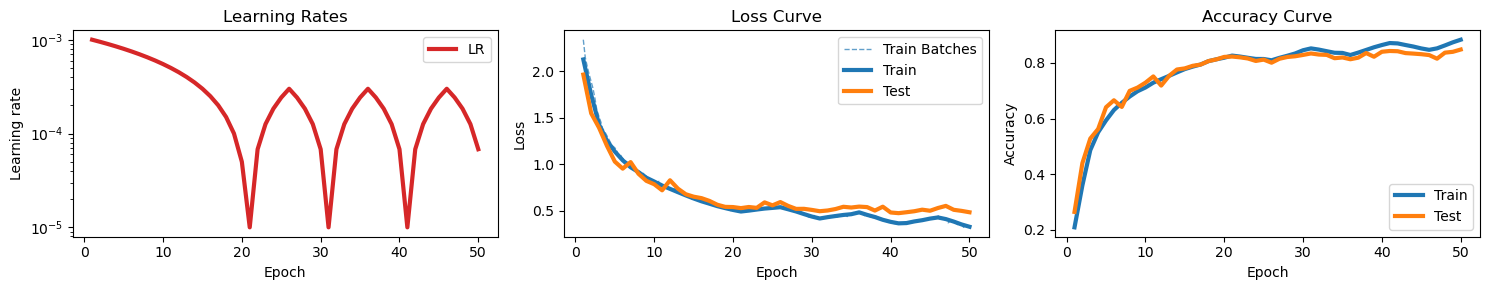

In [499]:
trainer.train(epochs=10, use_gpu=USE_GPU)
trainer.plot()

Epoch 51 :   0%|          | 0/196 [00:00<?, ?it/s]

[51,    49] loss: 0.310
[51,    98] loss: 0.305
[51,   147] loss: 0.312
[51,   196] loss: 0.311
Train Loss : 0.3095040238481395
Train Accuracy : 89.12 %
Val Loss : 0.4702766232192516
Accuracy of the network on the 10000 test images: 84.82 %


Epoch 52 :   0%|          | 0/196 [00:00<?, ?it/s]

[52,    49] loss: 0.311
[52,    98] loss: 0.319
[52,   147] loss: 0.316
[52,   196] loss: 0.330
Train Loss : 0.3192302791439757
Train Accuracy : 88.71 %
Val Loss : 0.4862108938395977
Accuracy of the network on the 10000 test images: 84.73 %
Finished Training


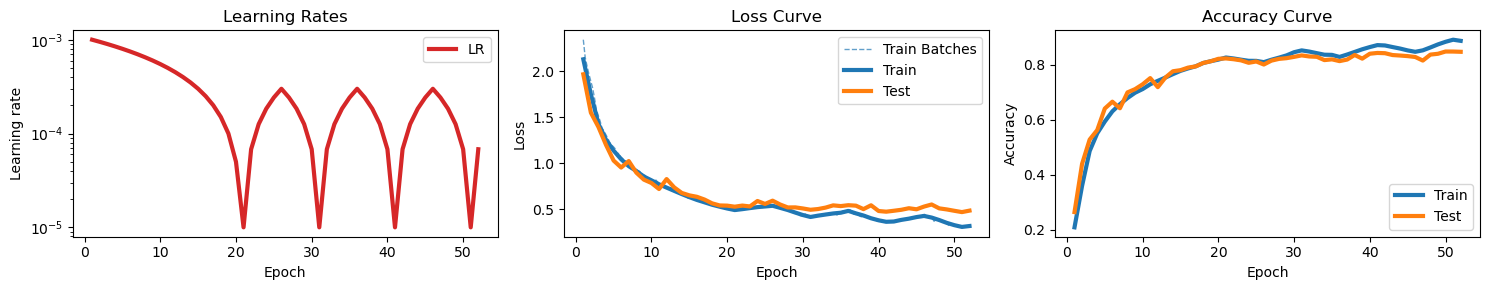

In [500]:
trainer.train(epochs=2, use_gpu=USE_GPU)
trainer.plot()

## Experiment

In [ ]:
class Model2(nn.Module):

  def __init__(self, channels, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
    super(Model2, self).__init__()
	
    self.debug=debug
    
    self.convs = nn.ModuleList(
        nn.Sequential(
            nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], kernel_size=kernel_size),
            #nn.BatchNorm2d(num_features=channels[i+1]),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
        )
        for i in range(n)
    )
    self.img_sizes = find_img_size(initial_img_size=IMG_DIM, depth=n+1, kernel_size=kernel_size, stride=1, pool=2)
    print(f"{self.img_sizes=}")
    
    #self.spaitial_average_pool = nn.AvgPool2d(kernel_size=self.img_sizes[-1])
    self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.linear = nn.Sequential(
        nn.Linear(in_features=channels[-1], out_features=len(CLASSES), bias=False),
    )

  def set_debug(self, debug=True):
    self.debug = debug

  def forward(self, x):

    #x = self.conv1(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv2(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv3(x)
    #if self.debug: print(f"M: {x.shape=}")
    
    for conv in self.convs:
        x = conv(x)
        if self.debug: print(f"M conv: {x.shape=}")
    
    f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"M: {f.shape=}")

    out = self.linear(f)
    if self.debug: print(f"M: {out.shape=}")

    return out